# Cross-Validation

In [56]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
# Data
DATA_DIRECTORY = os.path.join("..", "data")
DATASET_NAME = "BCA-1"
SAMPLE_NAME = "powder"
DOCUMENT_DIRECTORY = os.path.join("..", "docs")
PREDICTIONS_DIRECTORY = os.path.join(DATA_DIRECTORY, "predictions")
PREDICTION_FILE = f"prediction_corrected_{SAMPLE_NAME}_{DATASET_NAME}.csv"
TESTS_DIRECTORY = os.path.join(DATA_DIRECTORY, "tests")
TEST_FILE = f"test_{SAMPLE_NAME}_{DATASET_NAME}.csv"
COLORIMETRY_SYSTEM = "hsv"

# Plot
NAME_OF_LABEL = "Protein Concentration"
LABEL_UNIT = "\u03BCg/mL"
TITLE_FONT = {'fontname':'Times New Roman', 'size':'16', 'color':'black', 'weight':'heavy'}
AXIS_FONT = {'fontname':'Times New Roman', 'size':'12', 'weight':'heavy'}
LEGEND_FONT = {'family': 'Times New Roman', 'size': 12}
TITLE_DISPLAY = True
FIGURE_SIZE = (5, 5)
SAVE_FIGURE = True
FILTERED = False
FILTER_RANGE = (10, 80)

In [58]:
# Define a function to save figure
def save_fig(fig, fig_name, dataset_name, docs_dir):
    try:
        # Create /docs directory if doesn't exist
        if not os.path.exists(docs_dir):
            os.makedirs(docs_dir)
            print(f"Document directory is created at: {docs_dir}")
        
        # Create /dataset document directory if doesn't exist
        dataset_docs_dir = os.path.join(docs_dir, dataset_name)
        if not os.path.exists(dataset_docs_dir):
            os.makedirs(dataset_docs_dir)
            print(f"{dataset_name} directory is created at: {dataset_docs_dir}")

        # Save the figure
        fig_file = os.path.join(dataset_docs_dir, f"{fig_name}_{dataset_name}.png")
        fig.savefig(fig_file, dpi=300)
        print(f"Figure saved at: {os.path.abspath(fig_file)}")

    except Exception as e:
        print("Saving figure error occurred: {e}")

In [59]:
prediction_df = pd.read_csv(os.path.join(PREDICTIONS_DIRECTORY, PREDICTION_FILE))
test_df = pd.read_csv(os.path.join(TESTS_DIRECTORY, TEST_FILE))
common_labels = prediction_df[prediction_df['Label_Name'].isin(test_df['Label_Name'])]

validation_df = pd.DataFrame({
    'Label_Name': common_labels['Label_Name'],
    'Red': common_labels['Red'],
    'Green': common_labels['Green'],
    'Blue': common_labels['Blue'],
    'Predicted_Label': common_labels['Predicted_Label'],
    'Conc': test_df.set_index('Label_Name').loc[common_labels['Label_Name'], 'Conc'].values
})

# Drop rows where 'Conc' is '( - )'
validation_df = validation_df[validation_df['Conc'] != '( - )']

# Now, convert the columns to float
validation_df['Predicted_Label'] = validation_df['Predicted_Label'].astype(float)
validation_df['Conc'] = validation_df['Conc'].astype(float)
validation_df = validation_df.dropna()

# Filter the dataframe based on the criteria
if FILTERED == True:
    validation_df = validation_df[validation_df['Conc'].between(FILTER_RANGE[0], FILTER_RANGE[1])]

In [60]:
validation_df.head()

,Label_Name,Red,Green,Blue,Predicted_Label,Conc
35,1-D1,201.692457,178.118505,214.595336,26.496,78.0
36,1-D2,197.724942,171.612885,213.083346,27.904,76.0
37,1-D3,142.004675,103.546974,157.007914,66.672,77.0
38,1-D4,209.896950,188.624445,225.920610,16.864,120.0
39,1-D5,212.288930,192.541848,228.021976,16.352,121.0


In [61]:
# Colors based on RGB values from 'validation_df'
colors = [(row['Red']/255, row['Green']/255, row['Blue']/255) for _, row in validation_df.iterrows()]

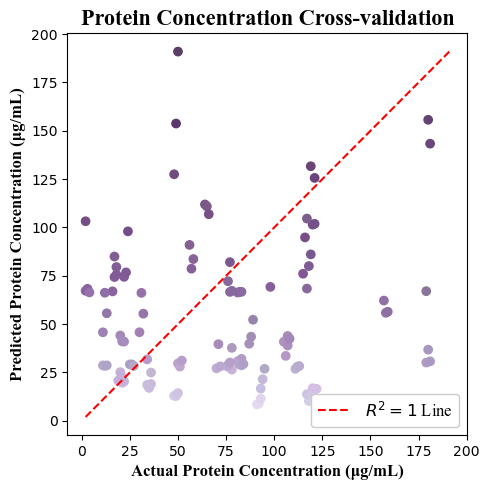

Figure saved at: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.1\docs\BCA-1\Cross-validation_powder_hsv_BCA-1.png


In [62]:
# Create subplots
fig, ax = plt.subplots(figsize=(FIGURE_SIZE[0], FIGURE_SIZE[1]))

# Plot Conc vs Predicted_Label
ax.scatter(validation_df['Conc'], validation_df['Predicted_Label'], color=colors)
ax.set_xlabel(f"Actual {NAME_OF_LABEL} ({LABEL_UNIT})", **AXIS_FONT)
ax.set_ylabel(f"Predicted {NAME_OF_LABEL} ({LABEL_UNIT})", **AXIS_FONT)

# Plotting the line for R-squared = 1
min_val = min(validation_df['Predicted_Label'].min(), validation_df['Conc'].min())
max_val = max(validation_df['Predicted_Label'].max(), validation_df['Conc'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='$R^2=1$ Line')

if TITLE_DISPLAY == True:
    ax.set_title(f'{NAME_OF_LABEL} Cross-validation', **TITLE_FONT)

# Display the plots
plt.tight_layout()
plt.legend(prop=LEGEND_FONT, framealpha=1)
plt.show()

# Save figure
if SAVE_FIGURE == True:
    save_fig(fig, f"Cross-validation_{SAMPLE_NAME}_{COLORIMETRY_SYSTEM}", DATASET_NAME, DOCUMENT_DIRECTORY)

In [63]:
# Calculate correlation
correlation = validation_df['Predicted_Label'].corr(validation_df['Conc'])

# Calculate the regression line's slope and intercept
slope, intercept = np.polyfit(validation_df['Conc'], validation_df['Predicted_Label'], 1)

# Calculate the R-squared value
r_squared = correlation**2

# Store the results in a new dataframe
validation_results_df = pd.DataFrame({
    'R-squared': [r_squared],
    'Correlation': [correlation],
    'Slope': [slope],
    'Intercept': [intercept],
})

In [64]:
validation_results_df.head()

,R-squared,Correlation,Slope,Intercept
0,0.008126,0.090146,0.069742,47.452734
